In [ ]:
import pandas as pd
import sys 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sys.path.append(r'C:\Users\Denis\credit_scoring\src\app\utils')
sys.path.append(r"C:\Users\Denis\credit_scoring\src\config")
sys.path.append(r'C:\Users\Denis\credit_scoring\src\app\modelling\features')
from db_handler import PostgresDBHandler
from db_config import DB_ARGS

pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.max_rows', None)     # Показывать все строки
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

In [2]:
db_handler = PostgresDBHandler(db_args=DB_ARGS)
db_handler.connect()

Соединение с PostgreSQL установлено.


In [ ]:
original_dir = os.getcwd()
os.chdir(r'C:\Users\Denis\credit_scoring\src\app\modelling\features')

# Запускаем скрипт с аргументами
#!python features_credit_card_balance.py --output_file "C:\data\features_1.csv"
!python features_bureau_balance.py --output_file "C:\data\features_2.csv"
!python features_application_train_test.py --output_file "C:\data\features_3.csv"
os.chdir(original_dir)

In [33]:
#credit_card_balance = pd.read_csv(r"C:\data\features_1.csv")
bureau_balance = pd.read_csv(r"C:\data\features_2.csv")
application_train_test = pd.read_csv(r"C:\data\features_3.csv")

#print("credit_card_balance shape: ", credit_card_balance.shape)
#print("bureau_balance shape: ", bureau_balance.shape)
print("application_train_test shape: ", application_train_test.shape)

application_train_test shape:  (356255, 15)


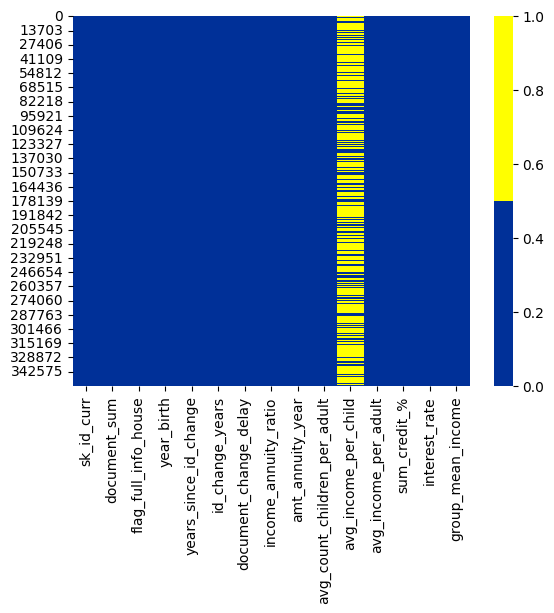

In [34]:
colours = ['#003098', '#ffff00'] 
sns.heatmap(application_train_test.isnull(), cmap=sns.color_palette(colours))
plt.show()

In [35]:
application_train_test = application_train_test.drop('avg_income_per_child', axis=1)

In [36]:
columns_to_select = [
    'sk_id_curr', 'target', 'name_contract_type', 'flag_own_car', 'flag_own_realty',
    'name_type_suite', 'name_income_type', 'region_population_relative',
    'days_employed', 'days_registration', 'own_car_age', 'flag_mobil',
    'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone',
    'flag_email', 'occupation_type', 'region_rating_client',
    'region_rating_client_w_city', 'weekday_appr_process_start',
    'hour_appr_process_start', 'reg_region_not_live_region',
    'reg_region_not_work_region', 'live_region_not_work_region',
    'reg_city_not_live_city', 'reg_city_not_work_city',
    'live_city_not_work_city', 'organization_type', 'ext_source_1',
    'ext_source_2', 'ext_source_3', 'obs_30_cnt_social_circle',
    'def_30_cnt_social_circle', 'obs_60_cnt_social_circle',
    'def_60_cnt_social_circle', 'days_last_phone_change',
    'amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day',
    'amt_req_credit_bureau_week', 'amt_req_credit_bureau_mon',
    'amt_req_credit_bureau_qrt', 'amt_req_credit_bureau_year']

In [37]:
query = f"""
SELECT {', '.join(columns_to_select)}
FROM application_train_test
"""
df = db_handler.get_df_from_query(query)
print(df.shape)

C:\Users\Denis\credit_scoring\src\app\utils\db_handler.py:65: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection, params=params)


(356255, 43)


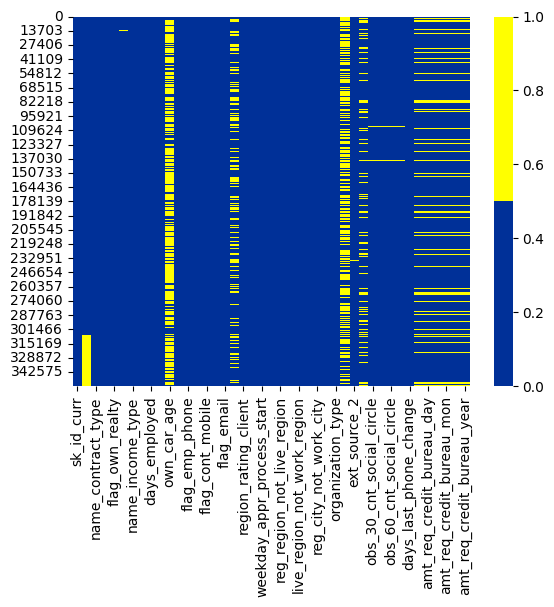

In [39]:
colours = ['#003098', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))
plt.show()

In [40]:
missing_values = df.isnull().sum()

# Подсчёт доли пропусков
missing_percentage = (missing_values / len(df)) * 100

# Создание DataFrame
missing_data = pd.DataFrame({
    'Feature': missing_values.index,  # Используем индексы из missing_values
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Сортировка по количеству пропусков
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Вывод результата
display(missing_data.head(30))

,Feature,Missing Values,Missing Percentage
10,own_car_age,235241,66.03
29,ext_source_1,193910,54.43
17,occupation_type,111996,31.44
31,ext_source_3,69633,19.55
1,target,48744,13.68
42,amt_req_credit_bureau_year,47568,13.35
41,amt_req_credit_bureau_qrt,47568,13.35
40,amt_req_credit_bureau_mon,47568,13.35
39,amt_req_credit_bureau_week,47568,13.35
38,amt_req_credit_bureau_day,47568,13.35


In [41]:
row = df[df['target'].isnull()]
df = df.drop(row.index, axis=0)

In [42]:
missing_values = df.isnull().sum()

# Подсчёт доли пропусков
missing_percentage = (missing_values / len(df)) * 100

# Создание DataFrame
missing_data = pd.DataFrame({
    'Feature': missing_values.index,  # Используем индексы из missing_values
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Сортировка по количеству пропусков
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Вывод результата
display(missing_data.head(10))

,Feature,Missing Values,Missing Percentage
10,own_car_age,202929,65.99
29,ext_source_1,173378,56.38
17,occupation_type,96391,31.35
31,ext_source_3,60965,19.83
42,amt_req_credit_bureau_year,41519,13.50
41,amt_req_credit_bureau_qrt,41519,13.50
40,amt_req_credit_bureau_mon,41519,13.50
39,amt_req_credit_bureau_week,41519,13.50
38,amt_req_credit_bureau_day,41519,13.50
37,amt_req_credit_bureau_hour,41519,13.50


In [43]:
columns_to_keep = missing_percentage[missing_percentage <= 15].index
df = df[columns_to_keep]
df = df.fillna(0)

### Предобработка датасета bureau_balance

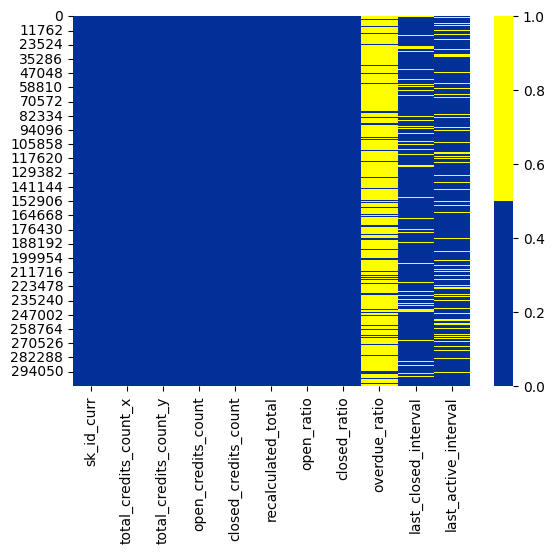

In [44]:
colours = ['#003098', '#ffff00'] 
sns.heatmap(bureau_balance.isnull(), cmap=sns.color_palette(colours))
plt.show()

составим рейтинг признаков по пропускам

In [45]:
missing_values = bureau_balance.isnull().sum()

# Подсчёт доли пропусков
missing_percentage = (missing_values / len(bureau_balance)) * 100

# Создание DataFrame
missing_data = pd.DataFrame({
    'Feature': missing_values.index,  # Используем индексы из missing_values
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Сортировка по количеству пропусков
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Вывод результата
display(missing_data.head(4))

,Feature,Missing Values,Missing Percentage
8,overdue_ratio,257289,84.13
10,last_active_interval,53996,17.66
9,last_closed_interval,37911,12.40
0,sk_id_curr,0,0.00


In [46]:
bureau_balance = bureau_balance.drop('overdue_ratio', axis=1).fillna(0)
missing_values = bureau_balance.isnull().sum()

# Подсчёт доли пропусков
missing_percentage = (missing_values / len(bureau_balance)) * 100

# Создание DataFrame
missing_data = pd.DataFrame({
    'Feature': missing_values.index,  # Используем индексы из missing_values
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Сортировка по количеству пропусков
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Вывод результата
display(missing_data.head(9))

,Feature,Missing Values,Missing Percentage
0,sk_id_curr,0,0.00
1,total_credits_count_x,0,0.00
2,total_credits_count_y,0,0.00
3,open_credits_count,0,0.00
4,closed_credits_count,0,0.00
5,recalculated_total,0,0.00
6,open_ratio,0,0.00
7,closed_ratio,0,0.00
8,last_closed_interval,0,0.00


In [47]:
#df = df.merge(credit_card_balance, on='sk_id_curr', how='left')
df = df.merge(bureau_balance, on='sk_id_curr', how='left')
df = df.merge(application_train_test, on='sk_id_curr', how='left')

In [48]:
def general_information(data):
    display(data.info())
    display(data.head(5))
    display(data.describe().T)
    display(data.isna().sum())

In [49]:
general_information(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   sk_id_curr                    307511 non-null  int64  
 1   target                        307511 non-null  float64
 2   name_contract_type            307511 non-null  object 
 3   flag_own_car                  307511 non-null  object 
 4   flag_own_realty               307511 non-null  object 
 5   name_type_suite               307511 non-null  object 
 6   name_income_type              307511 non-null  object 
 7   region_population_relative    307511 non-null  float64
 8   days_employed                 307511 non-null  int64  
 9   days_registration             307511 non-null  float64
 10  flag_mobil                    307511 non-null  object 
 11  flag_emp_phone                307511 non-null  object 
 12  flag_work_phone               307511 non-nul

None

,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,name_type_suite,name_income_type,region_population_relative,days_employed,days_registration,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_2,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,total_credits_count_x,total_credits_count_y,open_credits_count,closed_credits_count,recalculated_total,open_ratio,closed_ratio,last_closed_interval,last_active_interval,document_sum,flag_full_info_house,year_birth,years_since_id_change,id_change_years,document_change_delay,income_annuity_ratio,amt_annuity_year,avg_count_children_per_adult,avg_income_per_adult,sum_credit_%,interest_rate,group_mean_income
0,100277,0.00,Cash loans,Y,N,Unaccompanied,Pensioner,0.01,365243,-12539.00,1,0,0,1,1,0,2.00,2.00,THURSDAY,19,0,0,0,0,0,0,XNA,0.57,1.00,0.00,1.00,0.00,-318.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,59,13,46,1,4.17,194400.00,0.00,33750.00,49896.00,13.67,177755.25
1,100279,0.00,Cash loans,N,Y,Unaccompanied,Pensioner,0.07,365243,-6935.00,1,0,0,1,0,0,1.00,1.00,WEDNESDAY,16,0,0,0,0,0,0,XNA,0.46,0.00,0.00,0.00,0.00,-975.00,0.00,0.00,0.00,0.00,1.00,5.00,9.00,9.00,4.00,5.00,9.00,0.44,0.56,-226.00,-191.00,1,0,65,10,55,1,10.97,196884.00,0.00,180000.00,29700.00,11.66,177755.25
2,100281,0.00,Cash loans,N,Y,Unaccompanied,Commercial associate,0.03,-4942,-7868.00,1,1,1,1,0,0,2.00,2.00,THURSDAY,15,0,0,0,0,0,0,Self-employed,0.66,0.00,0.00,0.00,0.00,-1631.00,0.00,0.00,0.00,1.00,0.00,1.00,12.00,12.00,5.00,7.00,12.00,0.42,0.58,-272.00,-271.00,1,0,49,4,45,0,5.14,262872.00,1.00,112500.00,0.00,0.00,145221.35
3,100282,1.00,Revolving loans,Y,Y,Unaccompanied,Commercial associate,0.02,-146,-2926.00,1,1,0,1,0,0,2.00,2.00,THURSDAY,11,0,0,0,0,0,0,Insurance,0.52,1.00,1.00,1.00,1.00,-64.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,25,4,21,1,10.87,81000.00,0.00,73341.00,0.00,0.00,192680.50
4,100283,0.00,Cash loans,N,Y,Unaccompanied,Commercial associate,0.03,-870,-6120.00,1,1,0,1,0,0,2.00,2.00,SATURDAY,10,0,0,0,0,0,0,Self-employed,0.65,4.00,1.00,4.00,1.00,-914.00,0.00,0.00,1.00,0.00,0.00,1.00,2.00,2.00,0.00,2.00,2.00,0.00,1.00,-286.00,0.00,1,1,34,12,22,1,3.53,459216.00,0.00,67500.00,0.00,0.00,145221.35


,count,mean,std,min,25%,50%,75%,max
sk_id_curr,307511.00,278180.52,102790.18,100002.00,189145.50,278202.00,367142.50,456255.00
target,307511.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
region_population_relative,307511.00,0.02,0.01,0.00,0.01,0.02,0.03,0.07
days_employed,307511.00,63815.05,141275.77,-17912.00,-2760.00,-1213.00,-289.00,365243.00
days_registration,307511.00,-4986.12,3522.89,-24672.00,-7479.50,-4504.00,-2010.00,0.00
region_rating_client,307511.00,2.05,0.51,1.00,2.00,2.00,2.00,3.00
region_rating_client_w_city,307511.00,2.03,0.50,1.00,2.00,2.00,2.00,3.00
hour_appr_process_start,307511.00,12.06,3.27,0.00,10.00,12.00,14.00,23.00
reg_region_not_live_region,307511.00,0.02,0.12,0.00,0.00,0.00,0.00,1.00
reg_region_not_work_region,307511.00,0.05,0.22,0.00,0.00,0.00,0.00,1.00


sk_id_curr                          0
target                              0
name_contract_type                  0
flag_own_car                        0
flag_own_realty                     0
name_type_suite                     0
name_income_type                    0
region_population_relative          0
days_employed                       0
days_registration                   0
flag_mobil                          0
flag_emp_phone                      0
flag_work_phone                     0
flag_cont_mobile                    0
flag_phone                          0
flag_email                          0
region_rating_client                0
region_rating_client_w_city         0
weekday_appr_process_start          0
hour_appr_process_start             0
reg_region_not_live_region          0
reg_region_not_work_region          0
live_region_not_work_region         0
reg_city_not_live_city              0
reg_city_not_work_city              0
live_city_not_work_city             0
organization

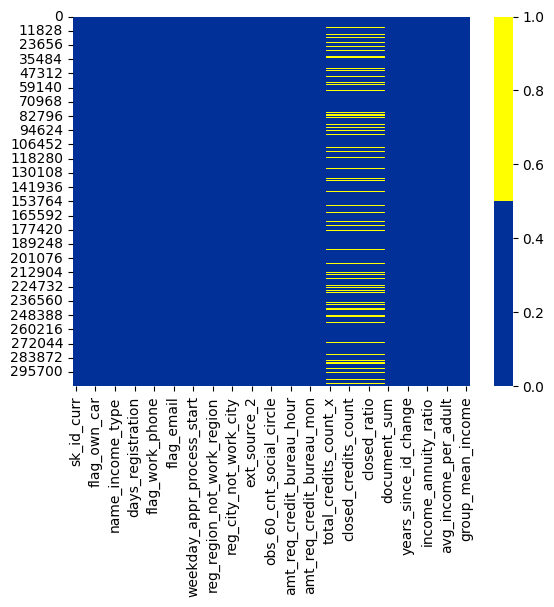

In [50]:
colours = ['#003098', '#ffff00'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))
plt.show()

In [51]:
missing_values = df.isnull().sum()

# Подсчёт доли пропусков
missing_percentage = (missing_values / len(df)) * 100

# Создание DataFrame
missing_data = pd.DataFrame({
    'Feature': missing_values.index,  # Используем индексы из missing_values
    'Missing Values': missing_values.values,
    'Missing Percentage': missing_percentage.values
})

# Сортировка по количеству пропусков
missing_data = missing_data.sort_values(by='Missing Values', ascending=False)

# Вывод результата
display(missing_data.head(5))

,Feature,Missing Values,Missing Percentage
46,last_closed_interval,44020,14.31
41,open_credits_count,44020,14.31
43,recalculated_total,44020,14.31
44,open_ratio,44020,14.31
45,closed_ratio,44020,14.31


In [52]:
df = df.dropna()

На этой стадии у меня возникло три гипотизы:
1) Клиенты которые находятся Заявки на кредит с типом "Cash loans" имеют более низки шанс стать дефолтом по сравнению с типом "Revolving loans"
2) Клиенты с типом дохода "Working" реже  становятся дефолтом, чем клиенты с типом дохода "Pensioner" или "Commercial associate".
3) Среднее значение доли открытых кредитов к доле закрытых кредитов различается хотя бы для одной группы типа дохода


### Проверка первой гипотизы

Проверим первую гипотизу, для этого сформулируем нулевую гипотизу и альтернативную,
- Нулевая гипотеза (H0): Нет разницы в шансах стать дефолтом между типами кредитов "Cash loans" и "Revolving loans".
- Альтернативная гипотеза (H1): Есть разница в шансах стать дефолтом между типами кредитов "Cash loans" и "Revolving loans".

In [53]:
df[['name_contract_type', 'target']].head(10)

,name_contract_type,target
1,Cash loans,0.00
2,Cash loans,0.00
4,Cash loans,0.00
5,Cash loans,0.00
6,Revolving loans,0.00
7,Cash loans,1.00
10,Cash loans,0.00
11,Cash loans,0.00
12,Cash loans,0.00
13,Cash loans,0.00


In [54]:
gip_1 = pd.crosstab(df["name_contract_type"], df["target"])
gip_1.columns = ['target_0', 'target_1']

gip_1.head(2)

,target_0,target_1
name_contract_type,,
Cash loans,219628,19081
Revolving loans,23270,1272


In [55]:
chi2, p, dof, expected = chi2_contingency(gip_1)

# Выводим результаты
print("Статистика хи-квадрат:", chi2)
print("p-значение:", p)
print("Степени свободы:", dof)
print("Ожидаемые значения:\n", expected)

# Проверка гипотез
alpha = 0.05
if p < alpha:
    print("Отклоняем нулевую гипотезу: тип кредита влияет на вероятность дефолта.")
else:
    print("Нет оснований отклонить нулевую гипотезу: тип кредита не влияет на вероятность дефолта.")

Статистика хи-квадрат: 246.01266097240097
p-значение: 1.9219541317699015e-55
Степени свободы: 1
Ожидаемые значения:
 [[220253.44132406  18455.55867594]
 [ 22644.55867594   1897.44132406]]
Отклоняем нулевую гипотезу: тип кредита влияет на вероятность дефолта.


Результаты теста хи-квадрат показывают, что тип кредита действительно влияет на вероятность дефолта. Выводы исходя из результата:

* Статистика хи-квадрат: 
`Значение 246.01 указывает на значительное отклонение наблюдаемых данных от ожидаемых при условии, что нулевая гипотеза верна. Чем выше значение хи-квадрат, тем сильнее отклонение.`

* p-значение: 
`Очень низкое значение ( p = 1.92 \times 10^{-55} ) говорит о том, что вероятность случайного получения таких данных при условии верности нулевой гипотезы практически равна нулю. Это позволяет с высокой уверенностью отвергнуть нулевую гипотезу.`

* Степени свободы: 
`( dof = 1 ) соответствует двум категориям (тип кредита) и одной степени свободы.`

* Ожидаемые значения: 
`Таблица ожидаемых значений показывает, как распределились бы данные, если бы тип кредита не влиял на вероятность дефолта. Наблюдаемые данные значительно отличаются от ожидаемых, что подтверждает влияние типа кредита.`

* Вывод: 
`Нулевая гипотеза ( H_0 ) ("тип кредита не влияет на вероятность дефолта") отвергается. Альтернативная гипотеза ( H_1 ) ("тип кредита влияет на вероятность дефолта") принимается. Это означает, что существует статистически значимая связь между типом кредита ("Cash loans" или "Revolving loans") и вероятностью дефолта.`

In [56]:
observed = gip_1  # ваши наблюдаемые данные
expected = expected  # ожидаемые данные из теста хи-квадрат

# Вычисляем отклонение
deviation = observed - expected

# Выводим разницу
print("Отклонение наблюдаемых от ожидаемых:\n", deviation)

# Вы можете также рассчитать процентное отклонение от ожидаемых значений
percent_deviation = (deviation / expected) * 100
print("Процентное отклонение:\n", percent_deviation)

Отклонение наблюдаемых от ожидаемых:
                     target_0  target_1
name_contract_type                    
Cash loans           -625.44    625.44
Revolving loans       625.44   -625.44
Процентное отклонение:
                     target_0  target_1
name_contract_type                    
Cash loans             -0.28      3.39
Revolving loans         2.76    -32.96


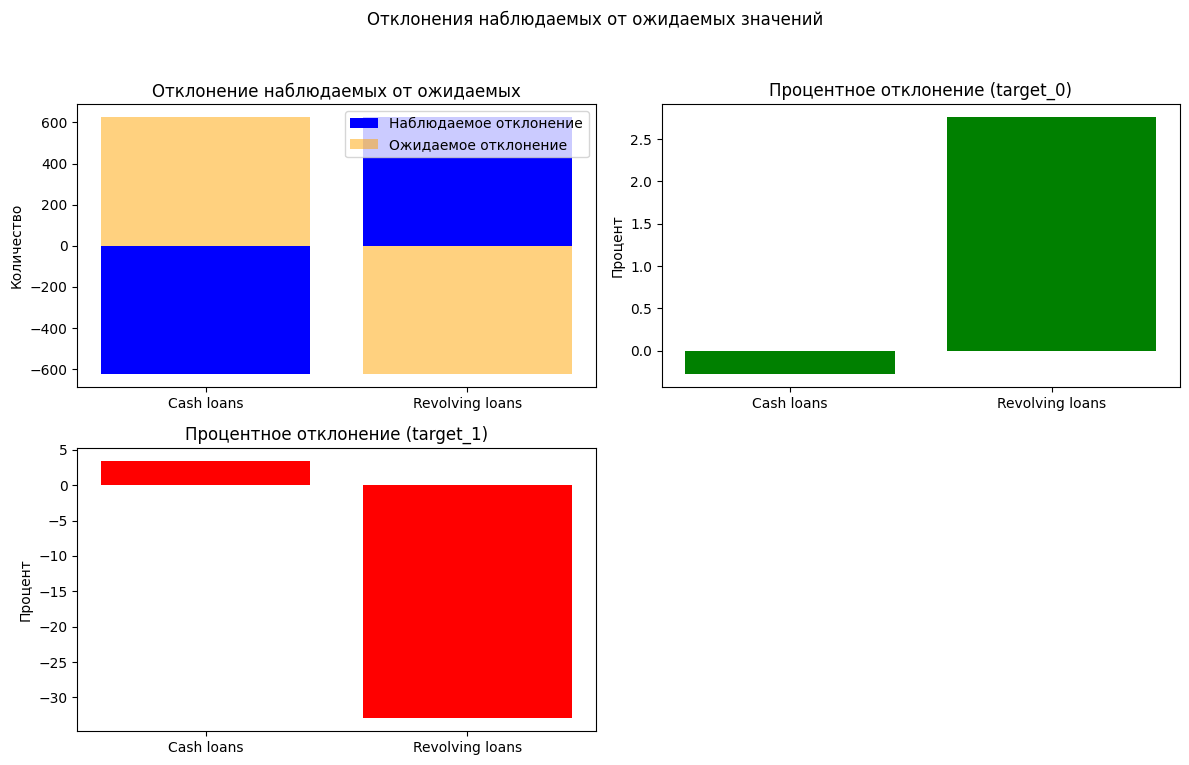

In [57]:
contract_types = ['Cash loans', 'Revolving loans']
observed_deviation = np.array([-625.44, 625.44])
expected_deviation = np.array([625.44, -625.44])
percent_deviation_0 = np.array([-0.28, 2.76])
percent_deviation_1 = np.array([3.39, -32.96])

# Создаем фигуру и оси
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Отклонения наблюдаемых от ожидаемых значений')

# 1. Отклонение
axes[0, 0].bar(contract_types, observed_deviation, color='blue', label='Наблюдаемое отклонение')
axes[0, 0].bar(contract_types, expected_deviation, color='orange', alpha=0.5, label='Ожидаемое отклонение')
axes[0, 0].set_title('Отклонение наблюдаемых от ожидаемых')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].legend()

# 2. Процентное отклонение (target_0)
axes[0, 1].bar(contract_types, percent_deviation_0, color='green')
axes[0, 1].set_title('Процентное отклонение (target_0)')
axes[0, 1].set_ylabel('Процент')

# 3. Процентное отклонение (target_1)
axes[1, 0].bar(contract_types, percent_deviation_1, color='red')
axes[1, 0].set_title('Процентное отклонение (target_1)')
axes[1, 0].set_ylabel('Процент')

# Убираем пустое подграфик
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Можем сделать вывод, что этот признак непосредственно оказывает сильное влияние на таргет

### Проверка второй гипотизы

Проверим вторую гипотизу, для этого сформулируем нулевую гипотизу и альтернативную,
- Нулевая гипотеза (H0): Нет разницы в шансах стать дефолтом между  типом дохода
- Альтернативная гипотеза (H1): Есть разница в шансах стать дефолтом между типом дохода

Клиенты с типом дохода "Working" реже  становятся дефолтом, чем клиенты с типом дохода "Pensioner" или "Commercial associate".

In [58]:
# Создаем таблицу контингентности
income_target_crosstab = pd.crosstab(df["name_income_type"], df["target"])
income_target_crosstab.columns = ['target_0', 'target_1']  # Переименуем столбцы для удобства
display(income_target_crosstab)

,target_0,target_1
name_income_type,,
Businessman,3,0
Commercial associate,56761,4413
Maternity leave,1,0
Pensioner,44573,2429
State servant,18292,1074
Student,15,0
Unemployed,5,0
Working,123248,12437


In [59]:
chi2, p, dof, expected = chi2_contingency(income_target_crosstab)

# Выводим результаты
print("Статистика хи-квадрат:", chi2)
print("p-значение:", p)
print("Степени свободы:", dof)
print("Ожидаемые значения:\n", expected)

# Проверка гипотез
alpha = 0.05  # Уровень значимости
if p < alpha:
    print("Отклоняем нулевую гипотезу: тип дохода влияет на вероятность дефолта.")
else:
    print("Нет оснований отклонить нулевую гипотезу: тип дохода не влияет на вероятность дефолта.")

Статистика хи-квадрат: 979.1539694916328
p-значение: 3.842484810517599e-207
Степени свободы: 7
Ожидаемые значения:
 [[2.76805786e+00 2.31942139e-01]
 [5.64443905e+04 4.72960947e+03]
 [9.22685954e-01 7.73140463e-02]
 [4.33680852e+04 3.63391480e+03]
 [1.78687362e+04 1.49726382e+03]
 [1.38402893e+01 1.15971069e+00]
 [4.61342977e+00 3.86570231e-01]
 [1.25194644e+05 1.04903564e+04]]
Отклоняем нулевую гипотезу: тип дохода влияет на вероятность дефолта.


Пройдём в этой гbпотизе ещё немного глубже и проверим тип дохода Commercial associate и Working

In [60]:
income_target_crosstab_type = income_target_crosstab[income_target_crosstab.index.isin(['Commercial associate', 'Working'])]
chi2, p, dof, expected = chi2_contingency(income_target_crosstab_type)

# Выводим результаты
print("Статистика хи-квадрат:", chi2)
print("p-значение:", p)
print("Степени свободы:", dof)
print("Ожидаемые значения:\n", expected)

# Проверка гипотез
alpha = 0.1  # Уровень значимости
if p < alpha:
    print("Отклоняем нулевую гипотезу: тип дохода влияет на вероятность дефолта.")
else:
    print("Нет оснований отклонить нулевую гипотезу: тип дохода не влияет на вероятность дефолта.")

Статистика хи-квадрат: 205.06707169760466
p-значение: 1.6373844771390263e-46
Степени свободы: 1
Ожидаемые значения:
 [[ 55937.85687218   5236.14312782]
 [124071.14312782  11613.85687218]]
Отклоняем нулевую гипотезу: тип дохода влияет на вероятность дефолта.


#### Результаты теста:

* Статистика хи-квадрат (chi2):
`Значение 205.07 указывает на значительное отклонение наблюдаемых данных от ожидаемых при условии, что нулевая гипотеза верна. Чем выше значение хи-квадрат, тем сильнее отклонение.`

* p-значение:
`Очень низкое значение (p = 1.64 × 10⁻⁴⁶) говорит о том, что вероятность случайного получения таких данных при условии верности нулевой гипотезы практически равна нулю. Это позволяет с высокой уверенностью отвергнуть нулевую гипотезу.`

* Степени свободы (dof):
`Значение 1 соответствует двум категориям (тип дохода: "Commercial associate" и "Working") и одной степени свободы.`

* Ожидаемые значения:
Таблица ожидаемых значений показывает, как распределились бы данные, если бы тип дохода не влиял на вероятность дефолта:

** Для "Commercial associate":

`Ожидаемые значения: 55,937.86 (target_0) и 5,236.14 (target_1).`

** Для "Working":

`Ожидаемые значения: 124,071.14 (target_0) и 11,613.86 (target_1).`

#### Наблюдаемые данные значительно отличаются от ожидаемых, что подтверждает влияние типа дохода.

### Проверка третий гипотизы

Сформулируем гипотезы:

* Нулевая гипотеза (H₀): Среднее значение df['mean'] одинаково для всех групп df['name_income_type'].
* Альтернативная гипотеза (H₁): Среднее значение df['mean'] различается хотя бы для одной группы df['name_income_type'].

F-статистика: 83.8439140951167
p-значение: 2.2136574826359242e-122
Отклоняем нулевую гипотезу: средние значения различаются между группами.


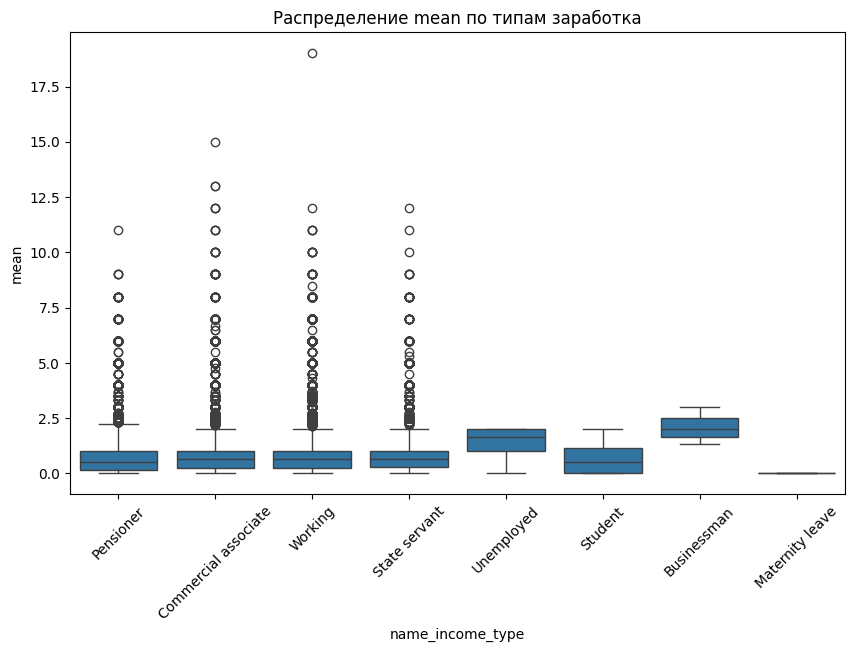

In [63]:
df['mean'] = df['open_credits_count'] / df['closed_credits_count'].replace(0, 1)
income_groups = [df[df['name_income_type'] == income_type]['mean'] for income_type in df['name_income_type'].unique()]

# 2. Выполняем однофакторный ANOVA-тест
f_stat, p_value = f_oneway(*income_groups)

# 3. Выводим результаты
print("F-статистика:", f_stat)
print("p-значение:", p_value)

# Проверка гипотезы
alpha = 0.1
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: средние значения различаются между группами.")
else:
    print("Нет оснований отклонить нулевую гипотезу: средние значения одинаковы между группами.")

# 4. Визуализация распределения
plt.figure(figsize=(10, 6))
sns.boxplot(x='name_income_type', y='mean', data=df)
plt.title('Распределение mean по типам заработка')
plt.xticks(rotation=45)
plt.show()

##### F-статистика (83.84):

`Это значение указывает на степень различий между группами по сравнению с вариацией внутри групп. Чем выше F-статистика, тем больше различий между группами относительно их внутренней вариации.`

##### p-значение (2.21e-122):

`Это значение показывает вероятность того, что наблюдаемые различия между группами могли возникнуть случайно. Очень низкое p-значение (практически нулевое) говорит о том, что различия между группами статистически значимы.`
##### Вывод:

`Нулевая гипотеза (H₀), утверждающая, что средние значения одинаковы для всех групп, отвергается.`

`Альтернативная гипотеза (H₁), утверждающая, что средние значения различаются хотя бы для одной группы, принимается.`
##### Интерпретация:
`Это означает, что тип дохода оказывает значительное влияние на среднее значение переменной mean (отношение открытых кредитов к закрытым). Различия между группами по типу дохода статистически значимы, и это может быть важным фактором для дальнейшего анализа.`

In [64]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

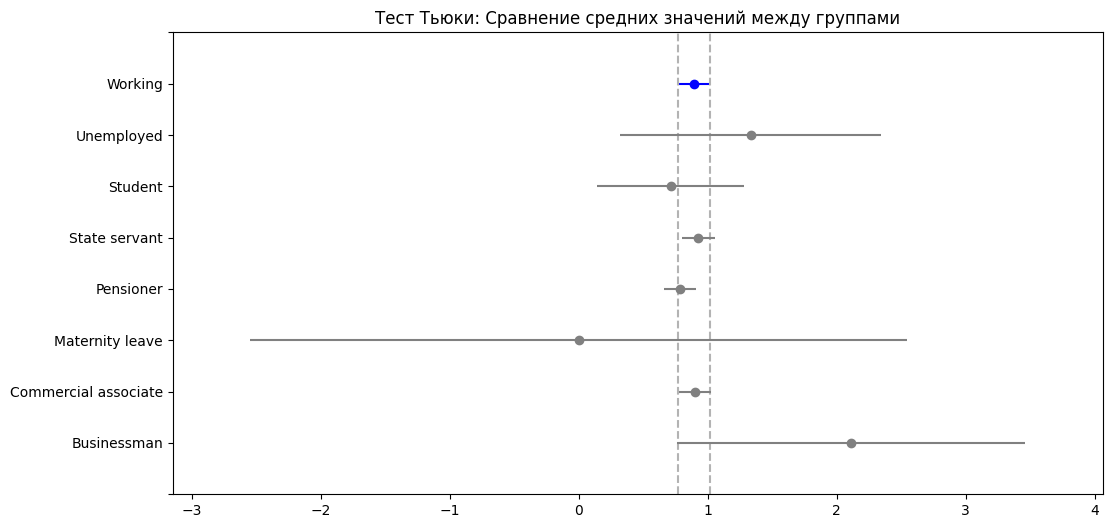

In [65]:
tukey_result = pairwise_tukeyhsd(
    endog=df['mean'],  # Зависимая переменная
    groups=df['name_income_type'],  # Группы
    alpha=0.05  # Уровень значимости
)

# Визуализация результатов
tukey_result.plot_simultaneous(comparison_name='Working', figsize=(12, 6))
plt.title('Тест Тьюки: Сравнение средних значений между группами')
plt.show()

Посмотрим на значения у которых выявленна статистически значимая разница

In [66]:
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

# Фильтруем строки, где reject == True
significant_results = tukey_df[tukey_df['reject'] == True]

# Выводим отфильтрованные результаты
print(significant_results)

                  group1         group2  meandiff  p-adj  lower  upper  reject
8   Commercial associate      Pensioner     -0.12   0.00  -0.14  -0.10    True
9   Commercial associate  State servant      0.03   0.02   0.00   0.05    True
18             Pensioner  State servant      0.15   0.00   0.12   0.17    True
21             Pensioner        Working      0.11   0.00   0.09   0.12    True
24         State servant        Working     -0.04   0.00  -0.06  -0.01    True


-    group1: Первая группа.
-    group2: Вторая группа.
-    meandiff: Разница средних.
-    p-adj: Скорректированное p-значение.
 -   reject: Логическое значение, указывающее, отвергается ли нулевая
 - гипотеза.

#### Интерпретация строк:
##### Commercial associate vs Pensioner:

- Разница средних: -0.12.
- Скорректированное p-значение: 0.00 (значимая разница).
- Доверительный интервал: от -0.14 до -0.10.

`Вывод: Среднее значение для группы "Commercial associate" значительно ниже, чем для группы "Pensioner".`

#####Commercial associate vs State servant:

- Разница средних: 0.03.
- Скорректированное p-значение: 0.02 (значимая разница).
- Доверительный интервал: от 0.00 до 0.05.

`Вывод: Среднее значение для группы "Commercial associate" немного выше, чем для группы "State servant".`

##### Pensioner vs State servant:

- Разница средних: 0.15.
- Скорректированное p-значение: 0.00 (значимая разница).
- Доверительный интервал: от 0.12 до 0.17.

`Вывод: Среднее значение для группы "Pensioner" значительно выше, чем для группы "State servant".`

##### Pensioner vs Working:

- Разница средних: 0.11.
- Скорректированное p-значение: 0.00 (значимая разница).
- Доверительный интервал: от 0.09 до 0.12.

`Вывод: Среднее значение для группы "Pensioner" значительно выше, чем для группы "Working".`

##### State servant vs Working:

- Разница средних: -0.04.
- Скорректированное p-значение: 0.00 (значимая разница).
- Доверительный интервал: от -0.06 до -0.01.

`Вывод: Среднее значение для группы "State servant" немного ниже, чем для группы "Working".`

#### Общие выводы:
- Группа "Pensioner" имеет значительно более высокие средние значения по сравнению с другими группами, особенно с "Commercial associate" и "Working".
- Группа "State servant" имеет немного более низкие средние значения по сравнению с "Working".
- Все выявленные различия являются статистически значимыми, так как p-adj < 0.05 и колонка reject имеет значение True.